<a href="https://colab.research.google.com/github/alwanfa/neural-network-exploration/blob/main/HeartDiseaseClassificationFFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ucimlrepo

In [82]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

from sklearn.metrics import recall_score, precision_score, f1_score

In [126]:

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [127]:
df = pd.concat([X, y], axis = 1)
df.dropna(inplace=True)

In [128]:
mask = df['num']>0
df.loc[mask, 'num'] = 1


In [129]:
df["thal"].unique()

array([6., 3., 7.])

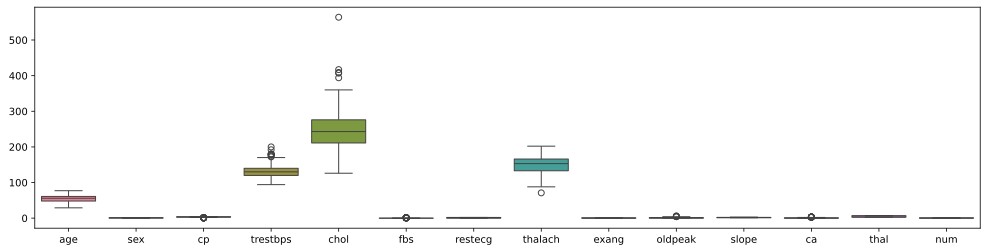

In [130]:
fig, ax = plt.subplots(1, figsize = (17,4))
ax = sns.boxplot(data = df)
plt.show()

In [36]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [131]:
hd_col = heart_disease.variables
cat_columns = ["sex", "fbs", "exang", "num"]
scalar_columns =  [i for i in df.columns if i not in cat_columns]

In [132]:
cat_columns = ["sex", "fbs", "exang"]

In [56]:
cat_columns

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

In [168]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1].values, test_size = .2, stratify=df.iloc[:,-1].values)

In [169]:
norm = StandardScaler().fit(X_train[scalar_columns])

In [170]:
def preprocessingPipeline(data):
  scalar_data = data[scalar_columns]
  categorical_data = data[cat_columns].values
  scale_data = norm.transform(scalar_data)
  new_data = np.hstack([scale_data, categorical_data])
  return new_data

In [171]:
X_train = preprocessingPipeline(X_train)
X_test = preprocessingPipeline(X_test)

<ipython-input-172-d23d9994c994>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels((df.iloc[:, :-1]).columns)


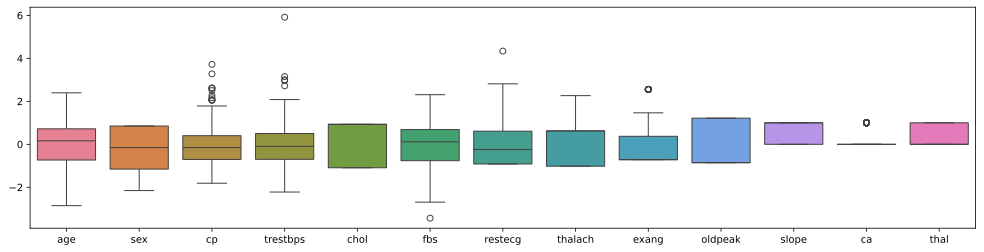

In [172]:
fig, ax = plt.subplots(1, figsize = (17,4))
ax = sns.boxplot(data = X_train)
ax.set_xticklabels((df.iloc[:, :-1]).columns)
plt.show()

In [204]:
batch_size = 16
X_train_tensor = torch.tensor(X_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_train_tensor = torch.tensor(y_train).float().reshape([-1,1])
y_test_tensor = torch.tensor(y_test).float().reshape([-1,1])
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [246]:
def createModel() :
  model = nn.Sequential(
      nn.Linear(13, 32),
      nn.ReLU(),
      nn.Linear(32, 16),
      nn.ReLU(),
      nn.Linear(16, 1),
  )
  lossfun = nn.BCEWithLogitsLoss()
  optim = torch.optim.Adam(model.parameters(), lr = .001)
  return model, lossfun, optim

In [181]:
train_loader.dataset.tensors[1].shape

torch.Size([237])

In [247]:
def trainModel(numEpochs) :
  epochs = numEpochs
  trainLoss = torch.zeros(epochs)
  testLoss = torch.zeros(epochs)
  trainAcc = torch.zeros(epochs)
  testAcc = torch.zeros(epochs)

  for epochi in range(epochs) :
    numloss = []
    batchAcc = []
    for X,y in train_loader :
      yHat = model(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      predict = (torch.sigmoid(yHat)>.5).float()
      acc = 100*(torch.mean((predict == y).float()))
      numloss.append(loss.item())
      batchAcc.append(acc.item())

    trainLoss[epochi] = np.mean(numloss)
    trainAcc[epochi] = np.mean(batchAcc)

    X_test, y_test = next(iter(test_loader))
    yHat = model(X_test)
    loss = lossfun(yHat,y_test)
    predict = (torch.sigmoid(yHat)>.5).float()
    acc = 100*(torch.mean((predict == y_test).float()))
    testAcc[epochi] = acc.item()
    testLoss[epochi] = loss.item()

  return trainLoss, testLoss, trainAcc, testAcc

In [248]:
model, lossfun, optimizer = createModel()

In [249]:
trainLoss, testLoss, trainAcc, testAcc = trainModel(50)

In [250]:
testAcc

tensor([65.0000, 78.3333, 83.3333, 86.6667, 86.6667, 85.0000, 86.6667, 86.6667,
        86.6667, 85.0000, 85.0000, 86.6667, 86.6667, 85.0000, 86.6667, 85.0000,
        86.6667, 86.6667, 86.6667, 86.6667, 86.6667, 86.6667, 85.0000, 86.6667,
        85.0000, 86.6667, 85.0000, 85.0000, 85.0000, 83.3333, 83.3333, 83.3333,
        83.3333, 83.3333, 83.3333, 81.6667, 81.6667, 83.3333, 83.3333, 81.6667,
        81.6667, 81.6667, 83.3333, 81.6667, 83.3333, 83.3333, 81.6667, 81.6667,
        83.3333, 83.3333])

In [251]:
trainLoss

tensor([0.6804, 0.6597, 0.6363, 0.6061, 0.5654, 0.5202, 0.4724, 0.4377, 0.4066,
        0.3928, 0.3788, 0.3760, 0.3613, 0.3543, 0.3472, 0.3401, 0.3354, 0.3279,
        0.3254, 0.3205, 0.3166, 0.3134, 0.3103, 0.3072, 0.3010, 0.2952, 0.2899,
        0.2862, 0.2828, 0.2790, 0.2769, 0.2692, 0.2730, 0.2622, 0.2573, 0.2543,
        0.2488, 0.2463, 0.2418, 0.2394, 0.2341, 0.2318, 0.2287, 0.2247, 0.2200,
        0.2151, 0.2127, 0.2068, 0.2044, 0.2025])

In [252]:
trainAcc

tensor([56.6987, 73.0449, 78.9744, 83.2372, 83.2372, 83.7500, 83.2372, 83.8782,
        84.4872, 84.2949, 83.9744, 83.1731, 84.8077, 84.7115, 84.8077, 84.9038,
        84.9038, 85.8333, 85.7372, 85.7372, 86.5705, 87.2115, 87.7244, 87.5321,
        87.7244, 87.8205, 88.2372, 88.6538, 88.7500, 88.6538, 88.4615, 88.7500,
        88.2692, 89.0705, 89.4872, 89.4872, 90.0000, 89.4872, 90.8333, 91.1538,
        91.2500, 90.6410, 90.9615, 91.8910, 91.1538, 91.5705, 91.1538, 92.0833,
        92.3077, 92.2115])

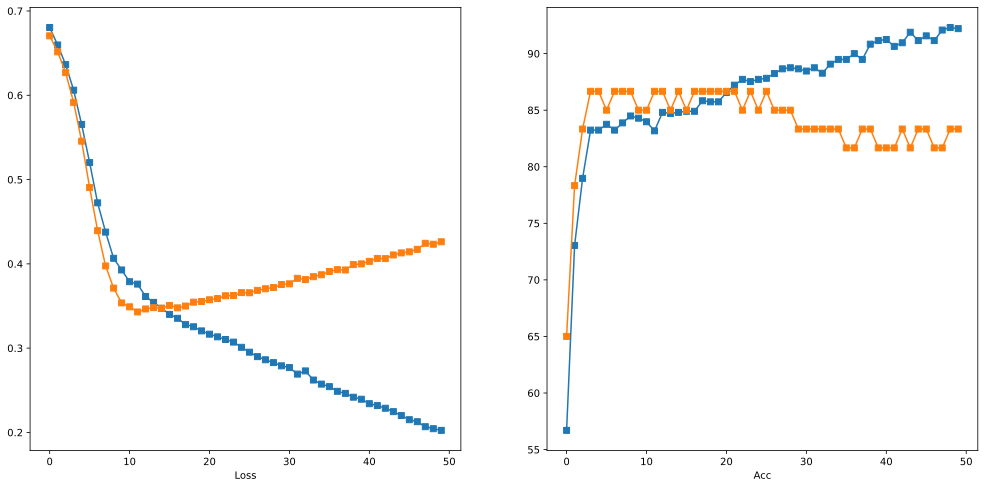

In [259]:
fig, ax = plt.subplots(1,2, figsize = (17,8))
ax[0].plot(trainLoss, "s-", label = "train")
ax[0].plot(testLoss, "s-", label = "test")
ax[0].set_xlabel("Loss")

ax[1].plot(trainAcc, "s-",label = "train")
ax[1].plot(testAcc,  "s-",label = "test")
ax[1].set_xlabel("Acc")

plt.show()